/tmp/ipython-input-1737691050.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=n, freq='M') #Dates mensuelles


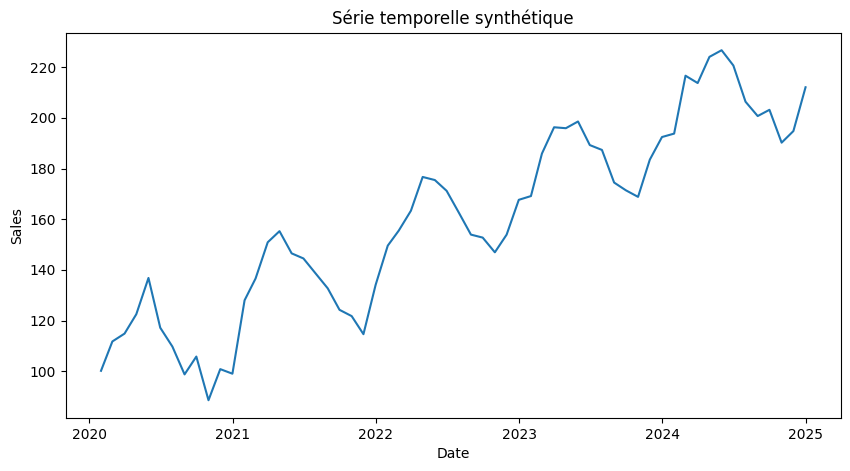

,Date,Sales
0,2020-01-31,100.159296
1,2020-02-29,111.748039
2,2020-03-31,114.840417
3,2020-04-30,122.499001
4,2020-05-31,136.803660


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

n = 60 #5 ans de données mensuelles
t= np.arange(n)
beta0 = 100 # Ordonnée à l'origine de la tendance
beta1 = 2 #Pente de la tendance
A = 20 # Amplitude de la seaisonnalité
P = 12 # Période de la saisonnalité (12 mois)
sigma = 5 # Ecart-type du bruit

#Génération des composantes
trend = beta0 + beta1 * t # Tendance linéaire
seasonality = A * np.sin(2 * np.pi * t / P) # Saisonnalité sinusoïdale
noise = np.random.normal(0, sigma, n) # Bruit gaussien

#Séries temporelle synthétique
sales = trend + seasonality + noise

#Création d'un DataFrame
dates = pd.date_range(start='2020-01-01', periods=n, freq='M') #Dates mensuelles
df = pd.DataFrame({'Date': dates, 'Sales': sales})

# -------- Plot --------
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Sales'])
plt.title("Série temporelle synthétique")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

df.head()

In [ ]:
# -------- 2. Test de stationnarité ADF --------
def test_adf(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print("La série est stationnaire (on rejette H0)")
    else:
        print("La série n'est pas stationnaire (on ne rejette pas H0)")

print("=== Test ADF sur série originale ===")
test_adf(df['Sales'])

=== Test ADF sur série originale ===
ADF Statistic: -0.5802762741919538
p-value: 0.8753767890575304
Critical Values:
   1%: -3.5714715250448363
   5%: -2.922629480573571
   10%: -2.5993358475635153
La série n'est pas stationnaire (on ne rejette pas H0)


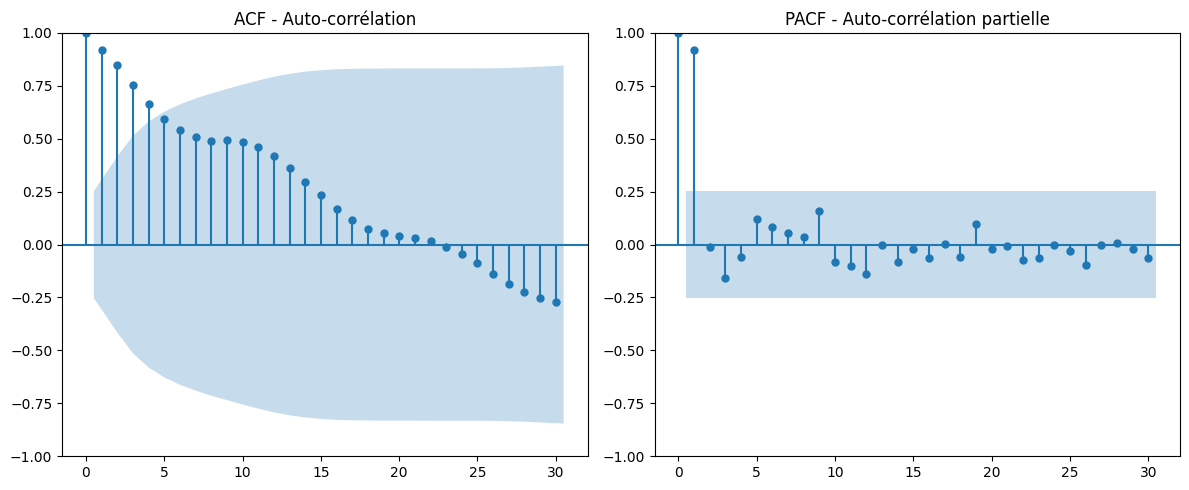

In [ ]:


# -------- 3. Visualisation ACF et PACF --------
max_lags = len(df['Sales']) // 2  # lags max = 50% de la série

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(df['Sales'], lags=max_lags, ax=plt.gca())
plt.title("ACF - Auto-corrélation")

plt.subplot(1,2,2)
plot_pacf(df['Sales'], lags=max_lags, ax=plt.gca())
plt.title("PACF - Auto-corrélation partielle")

plt.tight_layout()
plt.show()


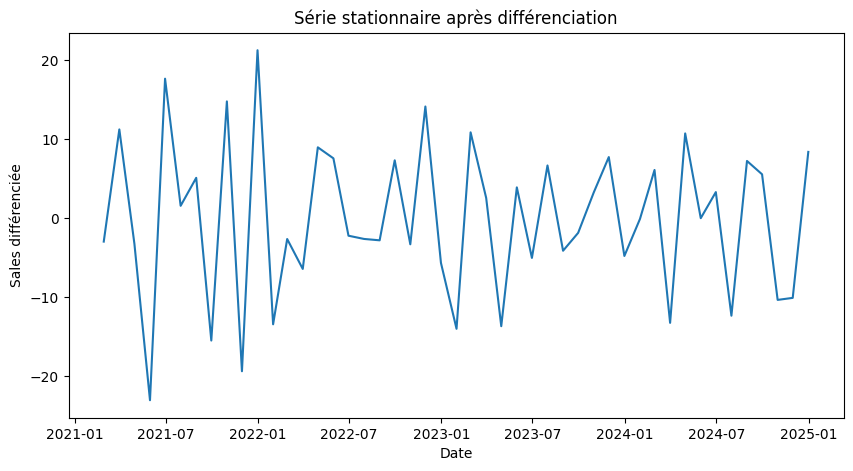

=== Test ADF sur série stationnaire ===
ADF Statistic: -8.177637583365787
p-value: 8.29406323569645e-13
Critical Values:
   1%: -3.5885733964124715
   5%: -2.929885661157025
   10%: -2.6031845661157025
La série est stationnaire (on rejette H0)


In [ ]:

# -------- 4. Rendre la série stationnaire --------
# Différenciation simple (pour enlever la tendance)
df['Sales_diff'] = df['Sales'].diff()

# Différenciation saisonnière (lag = 12 mois)
df['Sales_diff_season'] = df['Sales_diff'] - df['Sales_diff'].shift(P)

# Supprimer les NaN dus à la différenciation
df_stationary = df['Sales_diff_season'].dropna()

plt.figure(figsize=(10,5))
plt.plot(df['Date'][P+1:], df_stationary)
plt.title("Série stationnaire après différenciation")
plt.xlabel("Date")
plt.ylabel("Sales différenciée")
plt.show()

# Test ADF sur la série stationnaire
print("=== Test ADF sur série stationnaire ===")
test_adf(df_stationary)

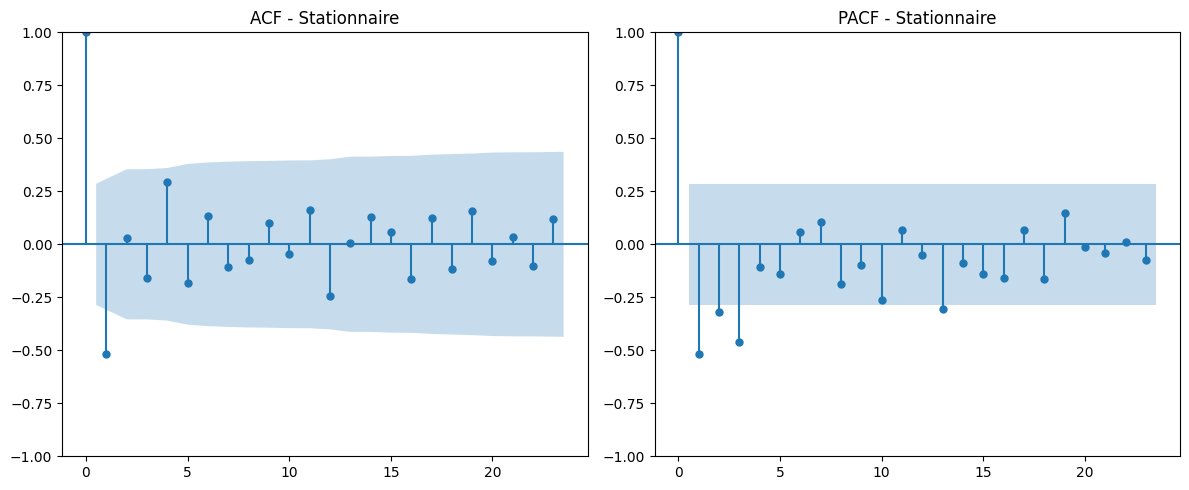

In [ ]:


# Visualisation ACF et PACF de la série stationnaire
max_lags_stationary = len(df_stationary) // 2
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(df_stationary, lags=max_lags_stationary, ax=plt.gca())
plt.title("ACF - Stationnaire")

plt.subplot(1,2,2)
plot_pacf(df_stationary, lags=max_lags_stationary, ax=plt.gca())
plt.title("PACF - Stationnaire")

plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -221.170
Date:                Mon, 27 Oct 2025   AIC                            448.339
Time:                        16:45:12   BIC                            454.572
Sample:                             0   HQIC                           450.772
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5126      0.487      1.052      0.293      -0.443       1.468
ma.L1         -0.2981      0.563     -0.529      0.597      -1.402       0.806
sigma2       105.4536     19.694      5.355      0.0

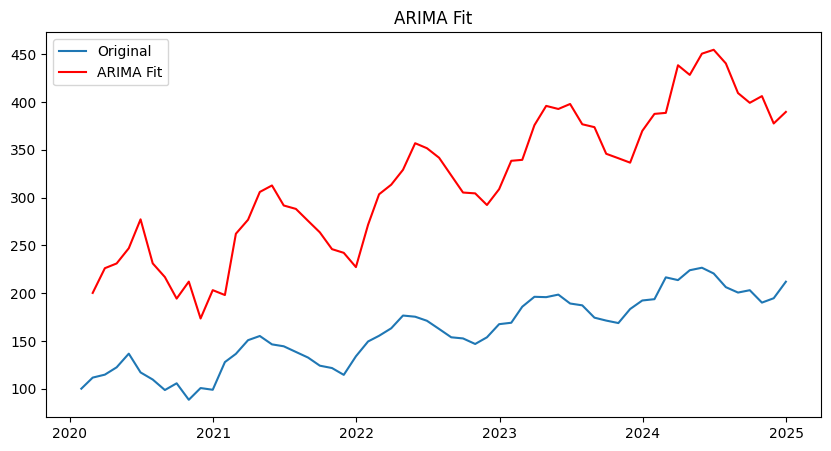

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# df['Sales'] contient notre série synthétique

# -------- 1. ARIMA (après différenciation simple) --------
# Ici on utilise d=1 pour enlever la tendance
arima_order = (1, 1, 1)  # p,d,q à ajuster
model_arima = ARIMA(df['Sales'], order=arima_order)
fit_arima = model_arima.fit()
print(fit_arima.summary())

# Prédiction ARIMA
df['ARIMA_pred'] = fit_arima.fittedvalues + df['Sales'].shift(1)  # Ajustement pour différenciation
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Sales'], label='Original')
plt.plot(df['Date'], df['ARIMA_pred'], label='ARIMA Fit', color='red')
plt.title("ARIMA Fit")
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -588.182
Date:                            Mon, 27 Oct 2025   AIC                           1186.363
Time:                                    16:45:18   BIC                           1193.846
Sample:                                         0   HQIC                          1188.881
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1059        nan        nan        nan         nan         nan
ma.L1         -0.9412         -0   

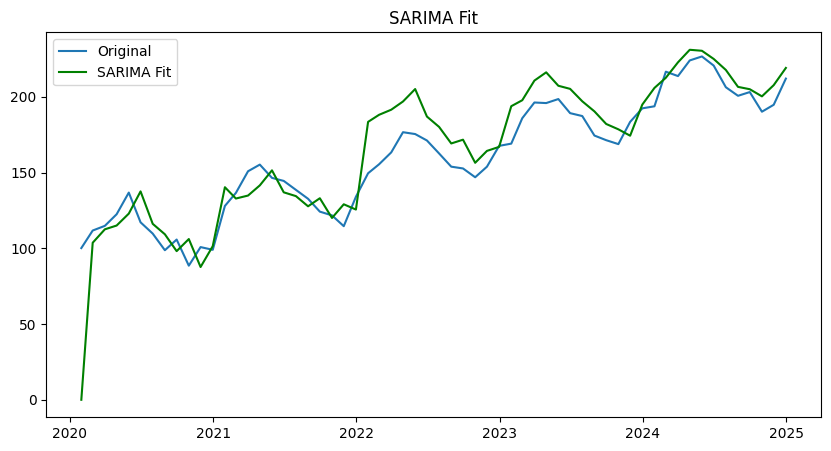

In [ ]:
# -------- 2. SARIMA (pour saisonnalité mensuelle P=12) --------
# (p,d,q) x (P,D,Q,s)
# d = 1 pour tendance, D = 1 pour saisonnalité, s = 12 (mensuelle)
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

model_sarima = SARIMAX(df['Sales'],
                       order=sarima_order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
fit_sarima = model_sarima.fit()
print(fit_sarima.summary())

# Prédiction SARIMA
df['SARIMA_pred'] = fit_sarima.fittedvalues

plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Sales'], label='Original')
plt.plot(df['Date'], df['SARIMA_pred'], label='SARIMA Fit', color='green')
plt.title("SARIMA Fit")
plt.legend()
plt.show()


Partie 2

/tmp/ipython-input-2814679625.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2015-01-01', periods=n, freq='M')


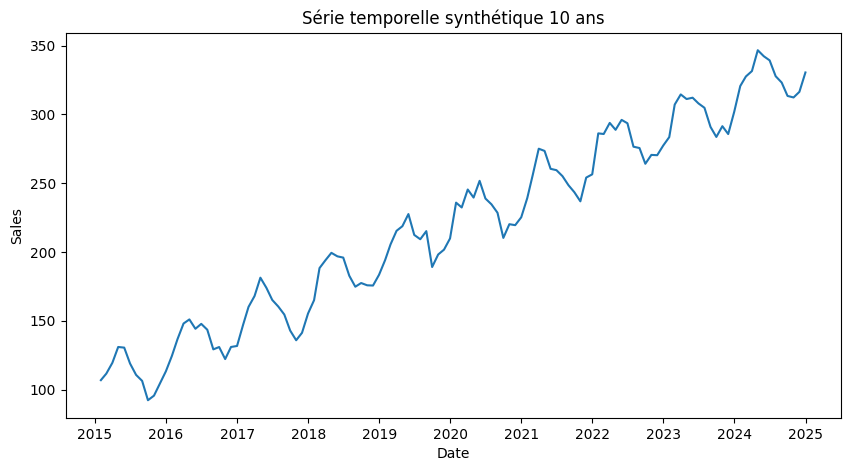

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -------- 1. Génération de la série synthétique 10 ans --------
n = 120              # 10 ans mensuelles
t = np.arange(n)
beta0 = 100          # Ordonnée à l'origine
beta1 = 2            # Pente
A = 20               # Amplitude saisonnalité
P = 12               # Période saisonnalité
sigma = 5            # Bruit

trend = beta0 + beta1 * t
seasonality = A * np.sin(2 * np.pi * t / P)
noise = np.random.normal(0, sigma, n)
sales = trend + seasonality + noise

dates = pd.date_range(start='2015-01-01', periods=n, freq='M')
df = pd.DataFrame({'Date': dates, 'Sales': sales})

plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Sales'])
plt.title("Série temporelle synthétique 10 ans")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [ ]:
# -------- 2. Séparation train/test --------
train = df['Sales'][:-12]  # 108 points
test = df['Sales'][-12:]   # dernière année

dates_train = df['Date'][:-12]
dates_test = df['Date'][-12:]

In [ ]:
# -------- 3. Test ADF sur train --------
def test_adf(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print("La série est stationnaire (on rejette H0)")
    else:
        print("La série n'est pas stationnaire (on ne rejette pas H0)")

print("=== Test ADF sur série train ===")
test_adf(train)

=== Test ADF sur série train ===
ADF Statistic: -0.878327314676164
p-value: 0.7950257411027415
Critical Values:
   1%: -3.5011373281819504
   5%: -2.8924800524857854
   10%: -2.5832749307479226
La série n'est pas stationnaire (on ne rejette pas H0)


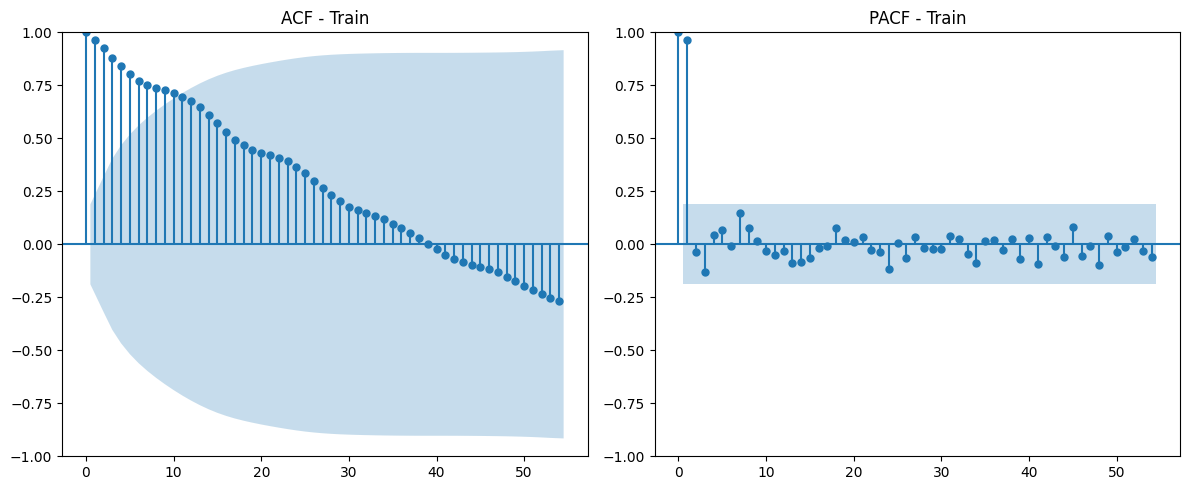

In [ ]:
# -------- 4. Visualisation ACF et PACF train --------
max_lags = len(train) // 2

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(train, lags=max_lags, ax=plt.gca())
plt.title("ACF - Train")

plt.subplot(1,2,2)
plot_pacf(train, lags=max_lags, ax=plt.gca())
plt.title("PACF - Train")
plt.tight_layout()
plt.show()

In [ ]:
# -------- 5. ARIMA sur train --------
arima_order = (1,1,1)
model_arima = ARIMA(train, order=arima_order)
fit_arima = model_arima.fit()
print(fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -397.956
Date:                Mon, 27 Oct 2025   AIC                            801.912
Time:                        16:49:45   BIC                            809.931
Sample:                             0   HQIC                           805.163
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5276      0.349      1.511      0.131      -0.157       1.212
ma.L1         -0.2891      0.402     -0.718      0.473      -1.078       0.500
sigma2        99.4621     14.058      7.075      0.0

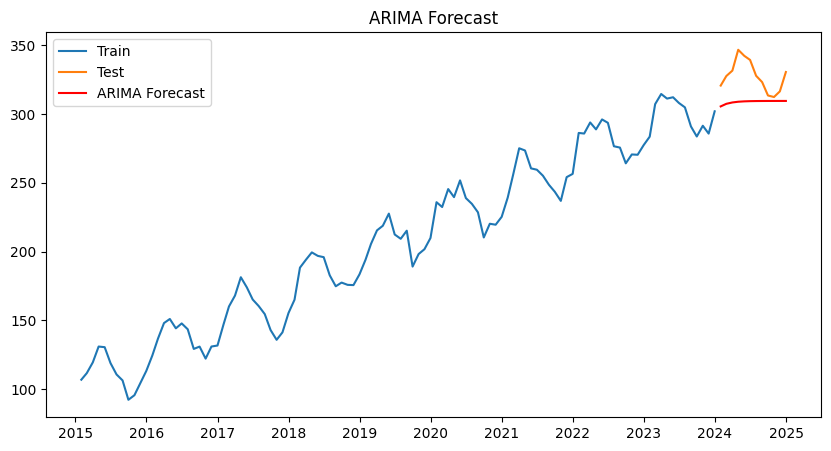

In [ ]:
# Prédiction sur train et test
pred_arima = fit_arima.get_forecast(steps=12)
pred_arima_mean = pred_arima.predicted_mean

plt.figure(figsize=(10,5))
plt.plot(dates_train, train, label='Train')
plt.plot(dates_test, test, label='Test')
plt.plot(dates_test, pred_arima_mean, label='ARIMA Forecast', color='red')
plt.title("ARIMA Forecast")
plt.legend()
plt.show()

In [ ]:
# -------- 6. SARIMA sur train --------
sarima_order = (1,1,1)
seasonal_order = (1,1,1,12)

model_sarima = SARIMAX(train,
                       order=sarima_order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
fit_sarima = model_sarima.fit()
print(fit_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -261.323
Date:                            Mon, 27 Oct 2025   AIC                            532.646
Time:                                    16:50:12   BIC                            544.618
Sample:                                         0   HQIC                           537.449
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1420      0.161     -0.883      0.377      -0.457       0.173
ma.L1         -0.8343      0.078   

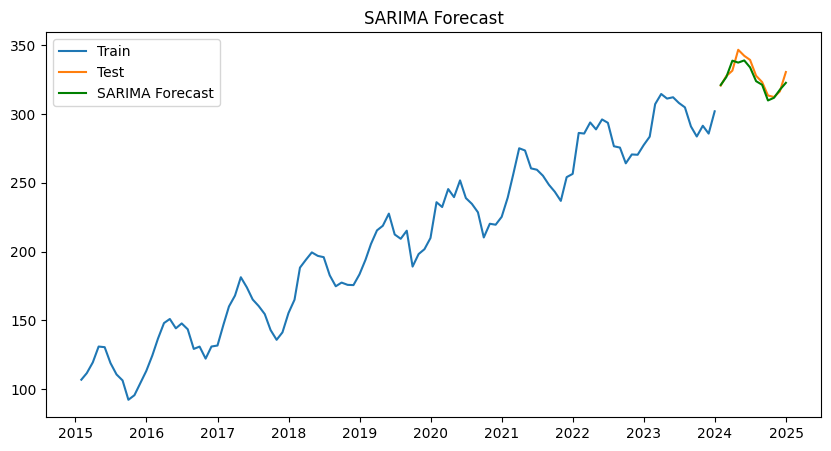

In [ ]:
# Prédiction sur test
pred_sarima = fit_sarima.get_forecast(steps=12)
pred_sarima_mean = pred_sarima.predicted_mean

plt.figure(figsize=(10,5))
plt.plot(dates_train, train, label='Train')
plt.plot(dates_test, test, label='Test')
plt.plot(dates_test, pred_sarima_mean, label='SARIMA Forecast', color='green')
plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [ ]:
# -------- 7. Évaluer performance --------
from sklearn.metrics import mean_squared_error

mse_arima = mean_squared_error(test, pred_arima_mean)
mse_sarima = mean_squared_error(test, pred_sarima_mean)
print(f"MSE ARIMA: {mse_arima:.2f}")
print(f"MSE SARIMA: {mse_sarima:.2f}")

MSE ARIMA: 469.27
MSE SARIMA: 23.00


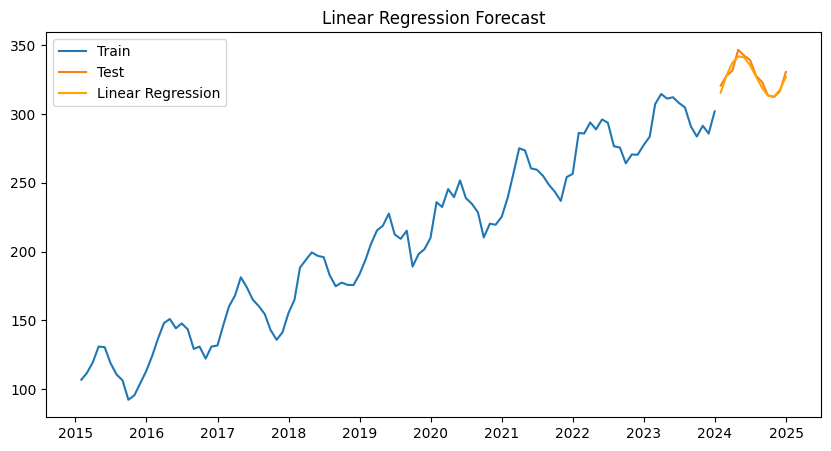

MSE Linear Regression : 10.83
MSE ARIMA            : 469.27
MSE SARIMA           : 23.00

--- Classement des modèles par MSE (plus petit = meilleur) ---
Linear      -> 10.83
SARIMA      -> 23.00
ARIMA       -> 469.27


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# ---- 1) Construire les features pour train et test ----
df['t'] = np.arange(len(df))
df['sin'] = np.sin(2 * np.pi * df['t'] / 12)
df['cos'] = np.cos(2 * np.pi * df['t'] / 12)

X = df[['t','sin','cos']]
y = df['Sales']

X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

# ---- 2) Entraîner la régression linéaire ----
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

# ---- 3) Prédire sur test ----
y_pred_lin = model_lin.predict(X_test)

# ---- 4) Visualisation ----
plt.figure(figsize=(10,5))
plt.plot(dates_train, y_train, label='Train')
plt.plot(dates_test, y_test, label='Test')
plt.plot(dates_test, y_pred_lin, label='Linear Regression', color='orange')
plt.title("Linear Regression Forecast")
plt.legend()
plt.show()

# ---- 5) Calcul du MSE ----
mse_lin = mean_squared_error(y_test, y_pred_lin)

print(f"MSE Linear Regression : {mse_lin:.2f}")
print(f"MSE ARIMA            : {mse_arima:.2f}")
print(f"MSE SARIMA           : {mse_sarima:.2f}")

# Comparaison simple
print("\n--- Classement des modèles par MSE (plus petit = meilleur) ---")
for name, mse in sorted([('Linear', mse_lin), ('ARIMA', mse_arima), ('SARIMA', mse_sarima)], key=lambda x: x[1]):
    print(f"{name:<10}  -> {mse:.2f}")
